# Main objective: Assessing OLST performance

###### In this script, we are using unsupervied machine learning to assess the performance of the One Leg Balance Test. For input metric, it is a N raws * 128 columns dataframe. The input parameters include different features during One Leg Balance Test trail such as 
* 1.	Lifting forefoot or heel  
* 2.   Moving hip into more than 30 degrees of flexion or abduction  
* 3.	Stepping, stumbling, or falling 
* 4.	Lifting hands off iliac crests


## Step 1: Load and create the dataset

In [138]:
import pandas as pd
import numpy as np
import os

In [139]:
### Direct to the correct folder
path = 'C:/Users/a1003/OneDrive/桌面/Thesis/data/OLBT/sub1to31'
filenames = os.listdir(path)   ### List the files name in the folder
sub_id = []                    ### Initialize the subject name list
value_list = []               ### Initialzie the value list

### Organize the information into different list and then integrate them together as a dataframe
for sub in filenames:
    curr_file = path + '/' + sub
    curr_csv = pd.read_csv(curr_file)
    value = list(curr_csv.loc[0])
    value_list.append(value)
    ID = str(curr_csv["sub_ID"][0]) ### -25: sub0?, -4: remove .csv
    sub_id.append(ID)
            
print("Current subject number: " + str(len(sub_id)) + '\n' + "Current features number: " + str(len(value)))

Current subject number: 50
Current features number: 39


In [140]:
### Create the correct columns name
col_names = list(curr_csv.columns)
all_col_names = ["sub_ID"] + col_names

In [141]:
### Create the correct metrix which is going to be convert to dataframe
all_list = []
for i in range(len(sub_id)):
    v = [(sub_id[i])] + value_list[i]
    all_list.append(v)

In [145]:
### Use the list and metrix above the create a new table
raw_df = pd.DataFrame(all_list, columns = all_col_names)
raw_df.columns = ['sub_ID', 'SL_fore_var_height', 'SL_heel_var_height',
       'OL_fore_var_height', 'OL_heel_var_height', 'SL_fore_mean_height',
       'SL_heel_mean_height', 'OL_fore_mean_height', 'OL_heel_mean_height',
       'SL_fore_max_height', 'SL_heel_max_height', 'OL_fore_max_height',
       'OL_heel_max_height', 'SL_var_flex', 'OL_var_flex', 'SL_mean_flex',
       'OL_mean_flex', 'SL_max_flex', 'OL_max_flex', 'SL_duration_flex',
       'OL_duration_flex', 'SL_var_abd', 'OL_var_abd', 'SL_mean_abd',
       'OL_mean_abd', 'SL_max_abd', 'OL_max_abd', 'SL_duration_abd',
       'OL_duration_abd', 'stepping_freq', 'stepping_duration', 'var_RL_dis',
       'Max_min_RL_dis', 'sub', 'foot_height_count', 'angle_count',
       'stepping_count', 'hand_iliac_count', 'out_position_count', 'totel']
NL_df = raw_df.drop(["sub"], axis = 1)
AM_df = raw_df.iloc[:, 33:]

In [59]:
#AM_df.to_csv("C:/Users/a1003/OneDrive/桌面/Thesis/excel_csv/new_assessment/automated_system_assessment.csv")

## Step 2: Preprocessing the data

* Missing data

In [146]:
### fill the missing data with average
df = NL_df.copy()
df_without_na = df.iloc[:,1:].copy()
for col in NL_df.columns:
    if df[col].isna().sum() != 0:
        df_without_na[col] = df_without_na[col].fillna(df[col].mean())
print("Amount of nan in original table: " + str(df.isna().sum().sum()) + '\n' + "Amount of nan in current table: " + str(df_without_na.isna().sum().sum()))

Amount of nan in original table: 0
Amount of nan in current table: 0


In [147]:
### normalize the dataset
from sklearn import preprocessing

normalized_df = pd.DataFrame()
for col in df_without_na.columns[:]:
    normalized_df[col] = preprocessing.normalize(np.array(df_without_na[col]).reshape(1, -1))[0]

In [148]:
#normalized_df

## Step 3: Feature selection

In [149]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [150]:
pca = PCA(n_components = 0.95)

In [151]:
pca.fit(normalized_df)


PCA(n_components=0.95)

In [152]:
pca.components_.shape

(13, 38)

In [153]:
#plt.plot(pca.components_[0])


In [154]:
#pca.components_

In [155]:
pca_normalized_df = pca.fit_transform(normalized_df)
pca_df_without_na = pca.fit_transform(df_without_na.iloc[:,1:])

In [156]:
pca_normalized_df.shape
### importance of the parameter

(50, 13)

## Step 4: Train and testing the model

In [157]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [158]:
#normalized_df = np.array(normalized_df)
#normalized_df

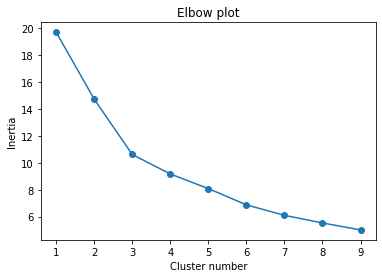

In [159]:
# pca_normalized_df 
# normalized_df 
# df_without_na.iloc[:,1:] (not normalized)
# pca_df_without_na  (not normalized)
x_train = normalized_df
inertia = []
for cluster in range(1,10):
    km = KMeans(n_clusters=cluster, random_state=0).fit(x_train)
    iner = km.inertia_
    inertia.append(iner)
plt.plot(range(1,10), inertia)
plt.title("Elbow plot")
plt.xlabel("Cluster number")
plt.ylabel("Inertia")
plt.scatter(range(1,10), inertia)

In [160]:
km_3 = KMeans(n_clusters=3, random_state=0).fit(x_train)
centers = km_3.cluster_centers_
labels = km_3.labels_

In [161]:
pd.set_option('display.max_rows', 100)
df_3 = pd.DataFrame({"Sub": sub_id, "Labels":labels})
df_3['Labels'] = df_3['Labels'].replace({0:'Good', 2:'Moderate', 1:'Bad'})
df_3_sorted = df_3.sort_values('Sub')

In [162]:
df_3_sorted.to_csv("Automated_compared_df.csv")

## Step 4: Evaluate the model

In [163]:
target_df = pd.read_csv("C:/Users/a1003/OneDrive/桌面/Thesis/assessing/OLBT_evaluation_sheet.csv") 

In [164]:
target_df = target_df[["sub_ID", "overall_rate"]]
#target_df

In [165]:
Automated_compared_df = df_3_sorted[(df_3_sorted['Sub'].isin(target_df['sub_ID']))].reset_index(drop=True)
Comparison_sorted_df = target_df[(target_df['sub_ID'].isin(Automated_compared_df['Sub']))].reset_index(drop=True)

In [166]:
comb_df_list = [Automated_compared_df, Comparison_sorted_df['overall_rate']]

In [167]:
comparison_df = pd.concat(comb_df_list, axis = 1)
comparison_df.columns = ['Sub', 'prediction', 'Target']

In [168]:
comparison_df

,Sub,prediction,Target
0,sub_01_EC_W2,Good,Good
1,sub_01_EP_W2,Good,Good
2,sub_02_EC_W2,Bad,Bad
3,sub_02_EP_W2,Good,Good
4,sub_03_EC_W2,Good,Bad
5,sub_03_EP_W2,Good,Good
6,sub_04_EC_W2,Good,Good
7,sub_04_EP_W2,Good,Good
8,sub_05_EC_W2,Bad,Bad
9,sub_05_EP_W2,Good,Moderate


## Accuracy

In [169]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

In [170]:
acc_3_t = accuracy_score(comparison_df['Target'], comparison_df['prediction'])
cm_3_t = confusion_matrix(comparison_df['Target'], comparison_df['prediction'])
recall = np.diag(cm_3_t) / np.sum(cm_3_t, axis = 1)
recall_3_t = np.mean(recall)
precision = np.diag(cm_3_t) / np.sum(cm_3_t, axis = 0)
precision_3_t = np.nanmean(precision)
print("acc: " + str(acc_3_t) + "\n" + "recall: " + str(recall_3_t) + "\n" + "precision: " + str(precision_3_t))

acc: 0.7142857142857143
recall: 0.6020114942528735
precision: 0.6158963585434173


## Confusion Matrix

In [171]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

* 3_clusters_model

#### Sensitivity

In [172]:
comparison_df

,Sub,prediction,Target
0,sub_01_EC_W2,Good,Good
1,sub_01_EP_W2,Good,Good
2,sub_02_EC_W2,Bad,Bad
3,sub_02_EP_W2,Good,Good
4,sub_03_EC_W2,Good,Bad
5,sub_03_EP_W2,Good,Good
6,sub_04_EC_W2,Good,Good
7,sub_04_EP_W2,Good,Good
8,sub_05_EC_W2,Bad,Bad
9,sub_05_EP_W2,Good,Moderate


In [173]:
# confusion_matrix(comparison_df['Target'], comparison_df['prediction'], labels = labels)
labels = ["Good", "Moderate", "Bad"]
origin_cm = confusion_matrix(comparison_df['Target'], comparison_df['prediction'], labels = labels)
transform_cm =confusion_matrix(comparison_df['Target'], comparison_df['prediction'], labels = labels)
transform_cm[:,0] = origin_cm[:,2]
transform_cm[:,2] = origin_cm[:,0]
transform_cm

array([[ 0,  2, 27],
       [ 3,  3,  6],
       [ 5,  2,  1]], dtype=int64)

In [174]:
transform_1 = np.array([[transform_cm[2,2], transform_cm[2,1], transform_cm[2,0]],
                 [transform_cm[1,2], transform_cm[1,1], transform_cm[1,0]],
                 [transform_cm[0,2], transform_cm[0,1], transform_cm[0,0]]
                ])

Text(0.5, 1.0, '3_clusters_model confusion matrix')

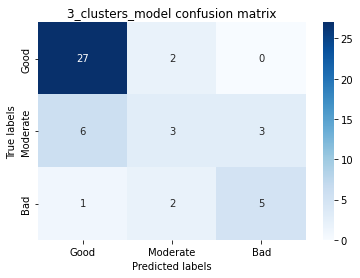

In [175]:
#labels = comparison_df['prediction'].unique()

cm = origin_cm
ax= plt.subplot()
sns.heatmap(cm, ax = ax, annot=True, cmap="Blues")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set_title("3_clusters_model confusion matrix")

In [176]:
B_index = list(labels).index("Bad")
M_index = list(labels).index("Moderate")
G_index = list(labels).index("Good")

Text(0.5, 1.0, '(3_clusters_model) Bad class prediction. Sensitivity (true positive rate): 62%')

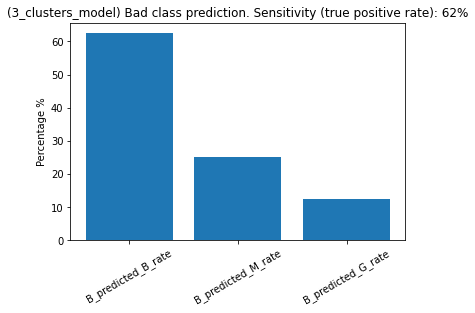

In [177]:
### Bad class error
B_predicted_B_rate = cm[B_index][B_index]/sum(cm[B_index][:])*100
B_predicted_M_rate = cm[B_index][M_index]/sum(cm[B_index][:])*100
B_predicted_G_rate = cm[B_index][G_index]/sum(cm[B_index][:])*100
ax = plt.subplot()
ax.bar(["B_predicted_B_rate", "B_predicted_M_rate", "B_predicted_G_rate"], [B_predicted_B_rate, B_predicted_M_rate, B_predicted_G_rate])
ax.set_ylabel("Percentage %")
plt.xticks(rotation=30)
ax.set_title("(3_clusters_model) Bad class prediction. " + "Sensitivity (true positive rate): " + str(round(B_predicted_B_rate)) + "%")

In [178]:
B_predicted_M_rate

25.0

Text(0.5, 1.0, '(3_clusters_model) Moderate class prediction. Sensitivity (true positive rate): 25%')

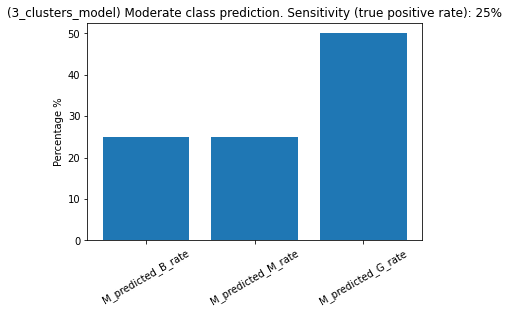

In [179]:
### Moderate class error
M_predicted_B_rate = cm[M_index][B_index]/sum(cm[M_index][:])*100
M_predicted_M_rate = cm[M_index][M_index]/sum(cm[M_index][:])*100
M_predicted_G_rate = cm[M_index][G_index]/sum(cm[M_index][:])*100
ax = plt.subplot()
ax.bar(["M_predicted_B_rate", "M_predicted_M_rate", "M_predicted_G_rate"], [M_predicted_B_rate, M_predicted_M_rate, M_predicted_G_rate])
ax.set_ylabel("Percentage %")
plt.xticks(rotation=30)
ax.set_title("(3_clusters_model) Moderate class prediction. " + "Sensitivity (true positive rate): " + str(round(M_predicted_M_rate)) + "%")

In [180]:
M_predicted_B_rate

25.0

Text(0.5, 1.0, '(3_clusters_model) Good class prediction. Sensitivity (true positive rate): 93%')

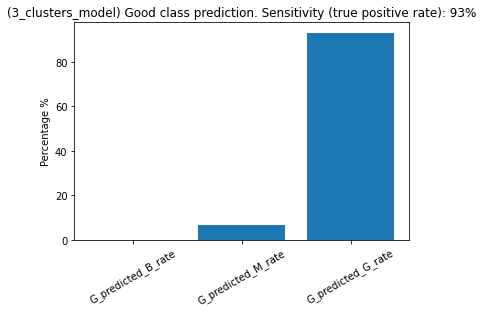

In [181]:
### Good class error
G_predicted_B_rate = cm[G_index][B_index]/sum(cm[G_index][:])*100
G_predicted_M_rate = cm[G_index][M_index]/sum(cm[G_index][:])*100
G_predicted_G_rate = cm[G_index][G_index]/sum(cm[G_index][:])*100
ax = plt.subplot()
ax.bar(["G_predicted_B_rate", "G_predicted_M_rate", "G_predicted_G_rate"], [G_predicted_B_rate, G_predicted_M_rate, G_predicted_G_rate])
ax.set_ylabel("Percentage %")
plt.xticks(rotation=30)
ax.set_title("(3_clusters_model) Good class prediction. " + "Sensitivity (true positive rate): " + str(round(G_predicted_G_rate)) + "%")

#### Precision (true predictive rate)

Text(0.5, 1.0, '(3_clusters_model) Bad class prediction. Precision (true predictive rate): 62%')

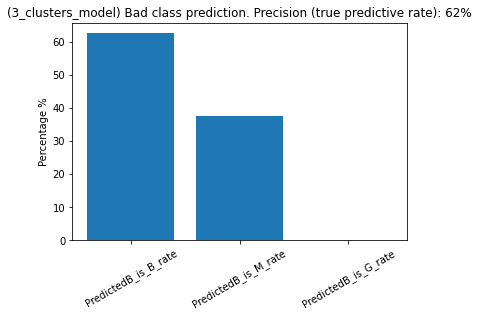

In [182]:
### Bad class error
PredictedB_is_B_rate = cm[B_index][B_index]/sum(cm[:,B_index])*100
PredictedB_is_M_rate = cm[M_index][B_index]/sum(cm[:,B_index])*100
PredictedB_is_G_rate = cm[G_index][B_index]/sum(cm[:,B_index])*100
ax = plt.subplot()
ax.bar(["PredictedB_is_B_rate", "PredictedB_is_M_rate", "PredictedB_is_G_rate"], [PredictedB_is_B_rate, PredictedB_is_M_rate, PredictedB_is_G_rate])
ax.set_ylabel("Percentage %")
plt.xticks(rotation=30)
ax.set_title("(3_clusters_model) Bad class prediction. " + "Precision (true predictive rate): " + str(round(PredictedB_is_B_rate)) + "%")

In [183]:
PredictedB_is_M_rate

37.5

Text(0.5, 1.0, '(3_clusters_model) Moderate class prediction. Precision (true predictive rate): 43%')

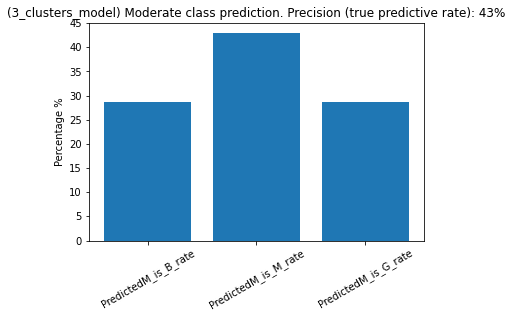

In [184]:
### Moderate class error
PredictedM_is_B_rate = cm[B_index][M_index]/sum(cm[:,M_index])*100
PredictedM_is_M_rate = cm[M_index][M_index]/sum(cm[:,M_index])*100
PredictedM_is_G_rate = cm[G_index][M_index]/sum(cm[:,M_index])*100
ax = plt.subplot()
ax.bar(["PredictedM_is_B_rate", "PredictedM_is_M_rate", "PredictedM_is_G_rate"], [PredictedM_is_B_rate, PredictedM_is_M_rate, PredictedM_is_G_rate])
ax.set_ylabel("Percentage %")
plt.xticks(rotation=30)
ax.set_title("(3_clusters_model) Moderate class prediction. " + "Precision (true predictive rate): " + str(round(PredictedM_is_M_rate)) + "%")

In [185]:
PredictedM_is_G_rate

28.57142857142857

Text(0.5, 1.0, '(3_clusters_model) Good class prediction. Precision (true predictive rate): 79%')

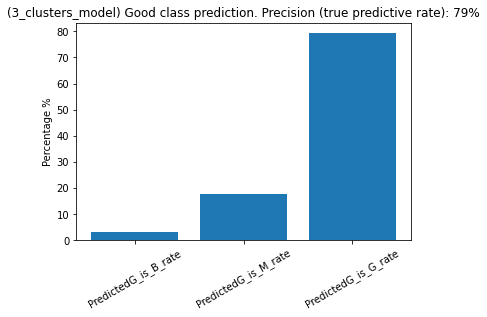

In [186]:
### Good class error
PredictedG_is_B_rate = cm[B_index][G_index]/sum(cm[:,G_index])*100
PredictedG_is_M_rate = cm[M_index][G_index]/sum(cm[:,G_index])*100
PredictedG_is_G_rate = cm[G_index][G_index]/sum(cm[:,G_index])*100
ax = plt.subplot()
ax.bar(["PredictedG_is_B_rate", "PredictedG_is_M_rate", "PredictedG_is_G_rate"], [PredictedG_is_B_rate, PredictedG_is_M_rate, PredictedG_is_G_rate])
ax.set_ylabel("Percentage %")
plt.xticks(rotation=30)
ax.set_title("(3_clusters_model) Good class prediction. " + "Precision (true predictive rate): " + str(round(PredictedG_is_G_rate)) + "%")

In [187]:
PredictedG_is_M_rate

17.647058823529413

## save model

In [103]:
import pickle

In [104]:
#pickle.dump(km_3, open("km_3_20062022.pkl", "wb"))

In [105]:
# load the model
# model = pickle.load(open("model.pkl", "rb"))

In [106]:
#comparison_df["Target"].to_csv("SL_target.csv")